In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [18]:
# X = np.random.uniform(low=-2, high=5, size=(6,8))
# ytrue = np.array([1,0,1,2,0,2])

def get_data(path):
    data = pd.read_csv(path, index_col=0)

    cols = list(data.columns)
    target = cols.pop()

    X = data[cols].copy()
    y = data[target].copy()

    y = LabelEncoder().fit_transform(y)

    return np.array(X), np.array(y)

X, y = get_data(r'C:\Users\12482\Desktop\articles\nn_from_scratch\iris.csv')

In [72]:
class DenseLayer:
    def __init__(self, neurons):
        self.neurons = neurons
        
    def relu(self, inputs):
        return np.maximum(0, inputs)

    def softmax(self, inputs):
        exp_scores = np.exp(inputs)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs
    
    def relu_derivative(self, dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z <= 0] = 0
        return dZ
    
    def forward(self, inputs, weights, bias, activation):
        Z_curr = np.dot(inputs, weights.T) + bias
        
        if activation == 'relu':
            A_curr = self.relu(inputs=Z_curr)
        elif activation == 'softmax':
            A_curr = self.softmax(inputs=Z_curr)
            
        return A_curr, Z_curr
    
    def backward(self, dA_curr, W_curr, Z_curr, A_prev, activation):
        if activation == 'softmax':
            dW = np.dot(A_prev.T, dA_curr) ## backpropate the gradient to the parameters (W,b)
            db = np.sum(dA_curr, axis=0, keepdims=True)
            dA = np.dot(W_curr.T, dA_curr.T) ## --> next input for dW (this is dA)
        else:
            dZ = self.relu_derivative(dA_curr.T, Z_curr)
            dW = np.dot(A_prev.T, dZ)
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = np.dot(W_curr.T, dZ.T) ## --> next input for dW (this is dA)
            
        return dA, dW, db

class Network:
    def __init__(self):
        self.network = [] ## layers
        self.architecture = [] ## mapping input neurons --> output neurons
        self.params = [] ## W, b
        self.memory = [] ## Z, A
        self.gradients = [] ## dW, db
        
    def add(self, layer):
        self.network.append(layer)
            
    def _compile(self, data):
        for idx, layer in enumerate(self.network):
            if idx == 0:
                self.architecture.append({'input_dim':data.shape[1], 
                                          'output_dim':layer.neurons, 'activation':'relu'})
            if idx == len(self.network)-2:
                self.architecture.append({'input_dim':layer.neurons, 
                                          'output_dim':self.network[idx+1].neurons, 'activation':'softmax'})
            elif idx != len(self.network)-2 and idx != len(self.network)-1:
                self.architecture.append({'input_dim':layer.neurons, 
                                          'output_dim':self.network[idx+1].neurons, 'activation':'relu'})
            else:
                continue
                
        return self
    
    def _init_weights(self, data):
        self._compile(data)
        
        for i in range(len(self.architecture)):
            self.params.append({
                'W':np.random.uniform(low=-1, high=1, 
                  size=(self.architecture[i]['output_dim'], 
                        self.architecture[i]['input_dim'])),
                'b':np.zeros((1, self.architecture[i]['output_dim']))})
        
        return self
    
    def _forwardprop(self, data):
        A_curr = data
        
        for i in range(len(self.params)):
            A_prev = A_curr
            A_curr, Z_curr = self.network[i].forward(inputs=A_prev, weights=self.params[i]['W'], 
                                           bias=self.params[i]['b'], activation=self.architecture[i]['activation'])
            
            self.memory.append({'inputs':A_prev, 'Z':Z_curr})
            
        return A_curr
    
    def _backprop(self, predicted, actual):
        num_samples = len(actual)
        
        ## compute the gradient on predictions
        dscores = predicted
        dscores[range(num_samples),actual] -= 1
        dscores /= num_samples
        
        dA_prev = dscores
        
        for idx, layer in reversed(list(enumerate(self.network))):
            dA_curr = dA_prev
            
            A_prev = self.memory[idx]['inputs']
            Z_curr = self.memory[idx]['Z']
            W_curr = self.params[idx]['W']
            
            activation = self.architecture[idx]['activation']

            dA_prev, dW_curr, db_curr = layer.backward(dA_curr, W_curr, Z_curr, A_prev, activation)

            self.gradients.append({'dW':dW_curr, 'db':db_curr})
            
    def _update(self, lr=0.02):
        for idx, layer in enumerate(self.network):
            self.params[idx]['W'] -= lr * list(reversed(self.gradients))[idx]['dW'].T     
            self.params[idx]['b'] -= lr * list(reversed(self.gradients))[idx]['db']
    
    def _get_accuracy(self, predicted, actual):
        return np.mean(np.argmax(predicted, axis=1)==actual)
    
    def _calculate_loss(self, predicted, actual):
        samples = len(actual)
        
        probs = predicted / np.sum(predicted, axis=1, keepdims=True)
        correct_logprobs = -np.log(probs[range(samples),actual])
        data_loss = np.sum(correct_logprobs)/150

        return data_loss
    
    def train(self, X_train, y_train, epochs):
        self.loss = []
        self.accuracy = []
        
        self._init_weights(X_train)
        
        for i in range(epochs):
            yhat = self._forwardprop(X_train)
            self.accuracy.append(self._get_accuracy(predicted=yhat, actual=y_train))
            self.loss.append(self._calculate_loss(predicted=yhat, actual=y_train))
            
            self._backprop(predicted=yhat, actual=y_train)
            
            self._update()
            

model = Network()
model.add(DenseLayer(2))
model.add(DenseLayer(8))
model.add(DenseLayer(10))
model.add(DenseLayer(3))

model.train(X_train=X, y_train=y, epochs=80)

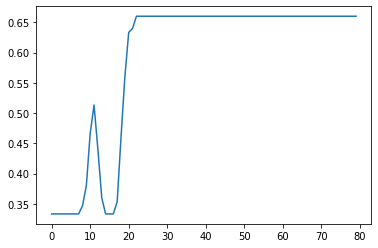

In [73]:
plt.plot(model.accuracy)

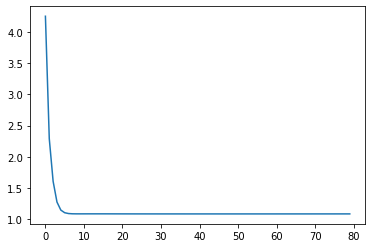

In [74]:
plt.plot(model.loss)

In [75]:
yhat = model._forwardprop(X[0])
np.argmax(yhat, axis=1)

array([0], dtype=int64)

In [62]:
y[0]

0

In [16]:
for idx, layer in enumerate(model.network):
    print(model.params[idx]['W'].shape, list(reversed(model.gradients))[idx]['dW'].T.shape)

(2, 4) (2, 4)
(8, 2) (8, 2)
(10, 8) (10, 8)
(6, 10) (6, 10)


In [14]:
print(model.params[0]['b'].shape)
print(model.params[1]['b'].shape)
print(model.params[2]['b'].shape)
print(model.params[3]['b'].shape)

(1, 2)
(1, 8)
(1, 10)
(1, 6)


In [13]:
print(model.gradients[0]['db'].shape)
print(model.gradients[1]['db'].shape)
print(model.gradients[2]['db'].shape)
print(model.gradients[3]['db'].shape)

(1, 6)
(1, 10)
(1, 8)
(1, 2)


In [11]:
list(reversed(model.gradients))[0]['dW'].shape

(4, 2)

In [8]:
d = list(reversed(model.gradients))
r = model.params[0]['W']- (0.01 * d[0]['dW'].T)

In [9]:
r

array([[-0.46389482,  0.56283981,  0.15665563,  0.74632185],
       [ 0.67504404,  0.11024425, -0.6045731 ,  0.87147938]])

In [83]:
print(model.params[0]['W'].shape)
print(model.params[1]['W'].shape)
print(model.params[2]['W'].shape)
print(model.params[3]['W'].shape)

(2, 4)
(8, 2)
(10, 8)
(6, 10)


In [84]:
print(model.gradients[3]['dW'].shape)
print(model.gradients[2]['dW'].shape)
print(model.gradients[1]['dW'].shape)
print(model.gradients[0]['dW'].shape)

(4, 2)
(2, 8)
(8, 10)
(10, 6)


In [69]:
#  compute the gradient on scores
dscores = yhat
dscores[range(150),y] -= 1
dscores /= 150

# backpropate the gradient to the parameters (W,b)
dW = np.dot(model.memory[3]['inputs'].T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)
dA_prev = np.dot(model.params[3]['W'].T, dscores.T) ## --> next input for dW (this is dA)

In [70]:
def relu_derivative(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    return dZ

dZ = relu_derivative(dA_prev.T, model.memory[2]['Z'])
dW1 = np.dot(model.memory[2]['inputs'].T, dZ)
db1 = np.sum(dZ, axis=0, keepdims=True)
dA_prev1 = np.dot(model.params[2]['W'].T, dZ.T) ## --> next input for dW (this is dA)

In [71]:
dZ1 = relu_derivative(dA_prev1.T, model.memory[1]['Z'])
dW2 = np.dot(model.memory[1]['inputs'].T, dZ1)
db2 = np.sum(dZ1, axis=0, keepdims=True)
dA_prev2 = np.dot(model.params[1]['W'].T, dZ1.T) ## --> next input for dW (this is dA)

In [72]:
dZ2 = relu_derivative(dA_prev2.T, model.memory[0]['Z'])
dW3 = np.dot(model.memory[0]['inputs'].T, dZ2)
db3 = np.sum(dZ2, axis=0, keepdims=True)
dA_prev3 = np.dot(model.params[0]['W'].T, dZ2.T) ## --> next input for dW (this is dA)

In [74]:
print(dW.shape, model.params[3]['W'].shape)
print(dW1.shape, model.params[2]['W'].shape)
print(dW2.shape, model.params[1]['W'].shape)
print(dW3.shape, model.params[0]['W'].shape)

(10, 6) (6, 10)
(8, 10) (10, 8)
(2, 8) (8, 2)
(4, 2) (2, 4)


In [39]:
for idx, layer in reversed(list(enumerate(model.architecture))):
    print(idx,layer)

3 {'input_dim': 10, 'output_dim': 3, 'activation': 'softmax'}
2 {'input_dim': 8, 'output_dim': 10, 'activation': 'relu'}
1 {'input_dim': 150, 'output_dim': 8, 'activation': 'relu'}
0 {'input_dim': 4, 'output_dim': 150, 'activation': 'relu'}
